In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [46]:
# 데이터 불러오기
df = pd.read_csv("./dataset/players_and_transf.csv")
df

,name,club,age,position,apps,mins,goals,assists,yel,red,shots,ps%,aerials_won,motm,rating,tackles,interceptions,fouls,offsides_won,clearances,dribbled,blocks,own_goals,key_passes,dribblings,fouled,offsides,dispossed,bad_controls,avg_passes,crosses,long_passes,through_passes,league,season,fee,traded,club_position
0,Arjen Robben,Bayern,26,FW,18(6),1779,16,6,1,-,3.4,80.2,0.4,8,8.18,0.6,0.5,0.9,-,-,0.7,-,-,1.8,4,2.2,0.3,2.1,-,34.3,1.5,2,0.2,Bundesliga,2009/2010,NaN,0,1
1,Arjen Robben,Bayern,26,FW,18(6),1779,16,6,1,-,3.4,80.2,0.4,8,8.18,0.6,0.5,0.9,-,-,0.7,-,-,1.8,4,2.2,0.3,2.1,-,34.3,1.5,2,0.2,Bundesliga,2009/2010,NaN,0,1
2,Stefan Kieling,Leverkusen,26,FW,33,2924,21,5,3,-,3,72.4,2.1,6,7.79,1.2,0.7,2.5,-,0.3,0.5,0.1,-,1.6,1.1,3.1,1.8,2.2,-,32.5,0.2,0.4,0.1,Bundesliga,2009/2010,NaN,0,4
3,Stefan Kieling,Leverkusen,26,FW,33,2924,21,5,3,-,3,72.4,2.1,6,7.79,1.2,0.7,2.5,-,0.3,0.5,0.1,-,1.6,1.1,3.1,1.8,2.2,-,32.5,0.2,0.4,0.1,Bundesliga,2009/2010,NaN,0,4
4,Zvjezdan Misimovic,Wolfsburg,28,FW,31,2768,10,13,7,-,2.4,77.5,0.2,8,7.74,1.9,0.6,1.5,-,0.2,1.2,0.1,-,3.3,1.5,2.1,0.3,3.1,-,51.1,2.5,5.7,0.5,Bundesliga,2009/2010,€8.50m,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71579,Ramzi Aya,Salernitana,32,Defender,2,136,-,-,1,-,0.5,76.2,-,-,5.31,0.5,-,0.5,-,2,-,-,-,-,-,-,-,-,-,10.5,-,-,-,Serie A,2021/2022,NaN,0,17
71580,Gianluca Pegolo,Sassuolo,41,GK,1,90,-,-,-,-,-,80,-,-,5.00,-,-,-,-,-,-,-,-,-,-,-,-,-,-,30,-,5,-,Serie A,2021/2022,NaN,0,11
71581,Gianluca Pegolo,Sassuolo,41,GK,1,90,-,-,-,-,-,80,-,-,5.00,-,-,-,-,-,-,-,-,-,-,-,-,-,-,30,-,5,-,Serie A,2021/2022,NaN,0,11
71582,Ionut Radu,Inter,25,GK,1,90,-,-,-,-,-,81,-,-,4.90,-,-,-,-,-,-,-,-,-,-,-,-,-,1,21,-,5,-,Serie A,2021/2022,loan transfer,1,2


In [60]:
# 확인
df.columns

Index(['age', 'apps', 'mins', 'goals', 'assists', 'yel', 'red', 'shots', 'ps%',
       'aerials_won', 'motm', 'rating', 'tackles', 'interceptions', 'fouls',
       'offsides_won', 'clearances', 'dribbled', 'blocks', 'own_goals',
       'key_passes', 'dribblings', 'fouled', 'offsides', 'dispossed',
       'bad_controls', 'avg_passes', 'crosses', 'long_passes',
       'through_passes', 'traded', 'pos_DF', 'pos_FW', 'pos_GK', 'pos_MF'],
      dtype='object')

In [48]:
# 필요없는 columns 없애기
df = df.drop(columns=['name', 'club', 'season','club_position', 'league', 'fee'])

In [49]:
# 반복되어있어서 홀수만 담기
df = df.iloc[1::2]

In [50]:
# 괄호 값 없애기
df['apps'] = df['apps'].str.replace(r'\(.*\)', '', regex=True).str.strip()

In [51]:
# -를 0으로
df = df.replace('-', 0)

In [52]:
# Nan값 없애기
df.isnull().sum()
df.dropna(inplace=True)

In [53]:
# 포지션 치환 딕셔너리
position_map = {
    # FW (공격수)
    'FW': 'FW', 'Forward': 'FW', 'forward': 'FW',

    # MF (미드필더)
    'M(C)': 'MF', 'M(CLR)': 'MF', 'M(CL)': 'MF', 'M(CR)': 'MF',
    'M(L)': 'MF', 'M(R)': 'MF', 'M(LR)': 'MF', 'Midfielder': 'MF',
    'midfielder': 'MF', 'DMC': 'MF',
    'AM(L)': 'MF', 'AM(R)': 'MF', 'AM(C)': 'MF', 'AM(CL)': 'MF',
    'AM(CR)': 'MF', 'AM(CLR)': 'MF', 'AM(LR)': 'MF',

    # DF (수비수)
    'D(C)': 'DF', 'D(CL)': 'DF', 'D(CR)': 'DF', 'D(CLR)': 'DF',
    'D(L)': 'DF', 'D(R)': 'DF', 'D(LR)': 'DF', 'Defender': 'DF',

    # GK (골키퍼)
    'GK': 'GK', 'Goalkeeper': 'GK'
}

# 치환 적용
df['position'] = df['position'].map(position_map)

position_dummies = pd.get_dummies(df['position'], prefix='pos')

# 기존 df와 결합
df = pd.concat([df.drop(columns=['position']), position_dummies], axis=1)

In [54]:
#데이터 프레임 확인
df.columns
df.shape

(35683, 35)

In [61]:
# 타입 바꾸기
df = df.apply(pd.to_numeric, errors='coerce')

In [62]:
df.dtypes

age                 int64
apps                int64
mins                int64
goals               int64
assists             int64
yel                 int64
red                 int64
shots             float64
ps%               float64
aerials_won       float64
motm                int64
rating            float64
tackles           float64
interceptions     float64
fouls             float64
offsides_won      float64
clearances        float64
dribbled          float64
blocks            float64
own_goals           int64
key_passes        float64
dribblings        float64
fouled            float64
offsides          float64
dispossed         float64
bad_controls      float64
avg_passes        float64
crosses           float64
long_passes       float64
through_passes    float64
traded              int64
pos_DF               bool
pos_FW               bool
pos_GK               bool
pos_MF               bool
dtype: object

In [63]:
from sklearn.model_selection import train_test_split

#dataset 나누기
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

# CSV로 저장
train_df.to_csv('./dataset/train.csv', index=False)
val_df.to_csv('./dataset/val.csv', index=False)
test_df.to_csv('./dataset/test.csv', index=False)

# 확인
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

Train shape: (28546, 35)
Validation shape: (3568, 35)
Test shape: (3569, 35)


In [64]:
from sklearn.model_selection import train_test_split

target_col = 'traded' 

# 2. X, y 분리
X = df.drop(columns=[target_col])
y = df[target_col]

# 3. test (10%) 먼저 분리
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# 4. 나머지 90%에서 validation (10%) 분리 → 전체의 10% = 0.1111 ≈ 1/9
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, random_state=42, stratify=y_temp
)

# 5. 결과 확인
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

X_train.to_csv('./dataset/x_train.csv', index=False)
X_val.to_csv('./dataset/x_val.csv', index=False)
X_test.to_csv('./dataset/x_test.csv', index=False)
y_train.to_csv('./dataset/y_train.csv', index=False)
y_val.to_csv('./dataset/y_val.csv', index=False)
y_test.to_csv('./dataset/y_test.csv', index=False)

Train shape: (28546, 34)
Validation shape: (3568, 34)
Test shape: (3569, 34)


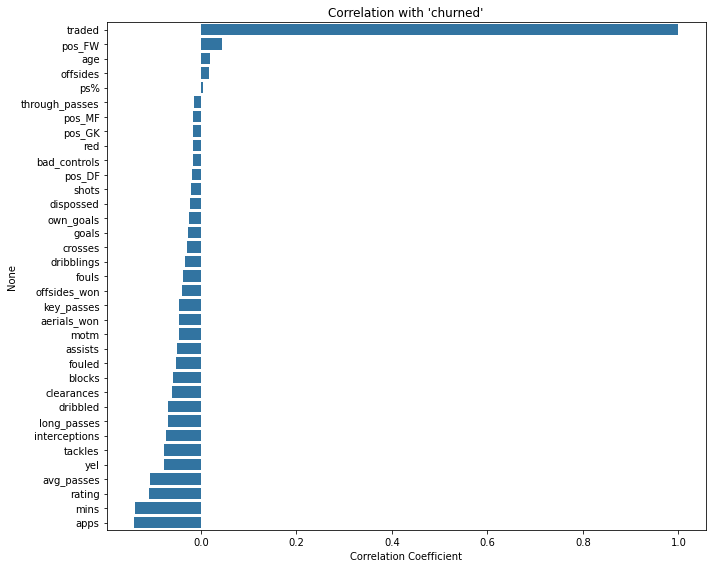

In [66]:
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

churn_corr = df.corr()['traded'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=churn_corr.values, y=churn_corr.index)
plt.title("Correlation with 'traded'")
plt.xlabel("Correlation Coefficient")
plt.tight_layout()
plt.show()